# Python Video Analysis

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import pathlib
import json

In [3]:
import cv2

In [4]:
import av

### Download mp4 from youtube

In [1]:
import yt_dlp

In [37]:
url = 'https://www.youtube.com/watch?v=thBfYfz1OaM'

ydl_opts = {
    'format': 'bestvideo+bestaudio/best',
    'merge_output_format': 'mp4',  # Always output MP4,
    'outtmpl': 'pbvideo/%(title)s.%(ext)s',  # Save as "title.mp4"
}

with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    ydl.download([url])

[youtube] Extracting URL: https://www.youtube.com/watch?v=thBfYfz1OaM
[youtube] thBfYfz1OaM: Downloading webpage
[youtube] thBfYfz1OaM: Downloading tv client config
[youtube] thBfYfz1OaM: Downloading player 22f02d3d-main
[youtube] thBfYfz1OaM: Downloading tv player API JSON
[youtube] thBfYfz1OaM: Downloading ios player API JSON
[youtube] thBfYfz1OaM: Downloading m3u8 information
[info] thBfYfz1OaM: Downloading 1 format(s): 616+251
[hlsnative] Downloading m3u8 manifest
[hlsnative] Total fragments: 582
[download] Destination: pbvideo/Staksrud⧸Patriquin v McGuffin⧸Bar at the Veolia North Carolina Open.f616.mp4
[download] 100% of    1.61GiB in 00:01:30 at 18.18MiB/s                  
[download] Destination: pbvideo/Staksrud⧸Patriquin v McGuffin⧸Bar at the Veolia North Carolina Open.f251.webm
[download] 100% of   40.87MiB in 00:00:01 at 28.80MiB/s    
[Merger] Merging formats into "pbvideo/Staksrud⧸Patriquin v McGuffin⧸Bar at the Veolia North Carolina Open.mp4"
Deleting original file pbvide

### Pass 1 Processing

Timing for 2000 frames:
 - convert to gray: 8.8s
 - tracker.track(): 13.5s

Original defaults:
```
threshold=10.0, maxCorners=100, qualityLevel=0.03, minDistance=30, blockSize=3, maxCount=30, epsilon=0.01
```

In [5]:
class CameraMotionTracker:

    def __init__(self, threshold=5.0, maxCorners=100, qualityLevel=0.03, minDistance=30,
                 blockSize=3, maxCount=30, epsilon=0.01):
        self.threshold = threshold
        self.feature_params = dict(
            maxCorners=maxCorners, qualityLevel=qualityLevel,
            minDistance=minDistance, blockSize=blockSize)
        self.maxCount = maxCount
        self.epsilon = epsilon
        self.prev_pts = None
        self.prev_gray = None
        self.motion = [ ]

    def track(self, gray, verbose=False):
        iframe = len(self.motion)
        if self.prev_gray is None:
            # first frame
            if verbose:
                print(f"frame[{iframe}] first frame")
            self.motion.append(-1)
        elif self.prev_pts is None:
            # calculate new tracking points from the previous frame
            if verbose:
                print(f"frame[{iframe}] calculate new tracking points from previous frame")
            self.motion.append(-1)
            self.prev_pts = cv2.goodFeaturesToTrack(self.prev_gray, mask=None, **self.feature_params)
        else:
            # calculate motion from the previous frame to the current frame using optical flow
            next_pts, status, err = cv2.calcOpticalFlowPyrLK(
                self.prev_gray, gray, self.prev_pts, None,
                winSize=(21,21), maxLevel=3,
                criteria=(cv2.TERM_CRITERIA_EPS|cv2.TERM_CRITERIA_COUNT, self.maxCount, self.epsilon))
            if next_pts is None or status is None:
                # failed to calculate optical flow
                if verbose:
                    print(f"frame[{iframe}] failed to calculate optical flow")
                self.motion.append(-1)
                self.prev_pts = None
            else:
                # find points that were successfully tracked
                good_mask = (status.flatten() == 1) & (err.flatten() < self.threshold)
                good_prev = self.prev_pts[good_mask]
                good_next = next_pts[good_mask]
                if good_prev.shape[0] < 5:
                    # not enough points in common to track
                    if verbose:
                        print(f"frame[{iframe}] not enough points in common to track: {good_prev.shape[0]}")
                    self.motion.append(-1)
                    self.prev_pts = None
                else:
                    disp = np.linalg.norm(good_next - good_prev, axis=1)
                    if verbose:
                        print(f"frame[{iframe}] {good_prev.shape[0]} points tracked, disp: {disp.mean():.2f}")
                    self.motion.append(float(disp.mean()))
                    self.prev_pts = good_next.reshape(-1,1,2) if good_next.size else None
        self.prev_gray = gray

In [10]:
def pass1(filename, maxframes=300, verbose=False):
    filename = pathlib.Path(filename)
    if not filename.exists():
        print(f"File {filename} does not exist")
        return
    container = av.open(filename, options={'hwaccel': 'videotoolbox'})
    stream = container.streams.video[0]
    fps = stream.average_rate
    nframes = stream.frames
    print(f"fps: {fps}, nframes: {nframes}")
    tracker = CameraMotionTracker()
    frame_times = []
    for iframe, frame in enumerate(container.decode(stream)):
        tframe = iframe / (92455000/3081833)
        frame_times.append(tframe)
        # Convert to numpy array
        img = frame.to_ndarray(format='bgr24')
        # Save the first frame to a JPG image
        if iframe == 0:
            cv2.imwrite(str(filename.with_suffix('.jpg')), img)
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Check for camera motion
        tracker.track(gray, verbose=verbose)
        if iframe % 1000 == 0:
            print(f"Frame {iframe}")
        if maxframes > 0 and iframe >= maxframes:
            break

    # Save results to a json file
    outname = filename.with_suffix('.json')
    print(f"Writing {outname}")
    motion = [ round(100 * m) for m in tracker.motion ]
    results = dict(name=str(filename), fps=float(fps), nframes=nframes,
                   motion=motion, frame_times=frame_times)
    with open(outname, 'w') as f:
        json.dump(results, f, indent=0)

    return tracker.motion

In [11]:
M = pass1('public/pbvideo/sample.mp4', maxframes=0, verbose=False)

fps: 92455000/3081833, nframes: 92455
Frame 0
Frame 1000
Frame 2000
Frame 3000
Frame 4000
Frame 5000
Frame 6000
Frame 7000
Frame 8000
Frame 9000
Frame 10000
Frame 11000
Frame 12000
Frame 13000
Frame 14000
Frame 15000
Frame 16000
Frame 17000
Frame 18000
Frame 19000
Frame 20000
Frame 21000
Frame 22000
Frame 23000
Frame 24000
Frame 25000
Frame 26000
Frame 27000
Frame 28000
Frame 29000
Frame 30000
Frame 31000
Frame 32000
Frame 33000
Frame 34000
Frame 35000
Frame 36000
Frame 37000
Frame 38000
Frame 39000
Frame 40000
Frame 41000
Frame 42000
Frame 43000
Frame 44000
Frame 45000
Frame 46000
Frame 47000
Frame 48000
Frame 49000
Frame 50000
Frame 51000
Frame 52000
Frame 53000
Frame 54000
Frame 55000
Frame 56000
Frame 57000
Frame 58000
Frame 59000
Frame 60000
Frame 61000
Frame 62000
Frame 63000
Frame 64000
Frame 65000
Frame 66000
Frame 67000
Frame 68000
Frame 69000
Frame 70000
Frame 71000
Frame 72000
Frame 73000
Frame 74000
Frame 75000
Frame 76000
Frame 77000
Frame 78000
Frame 79000
Frame 80000
Fra

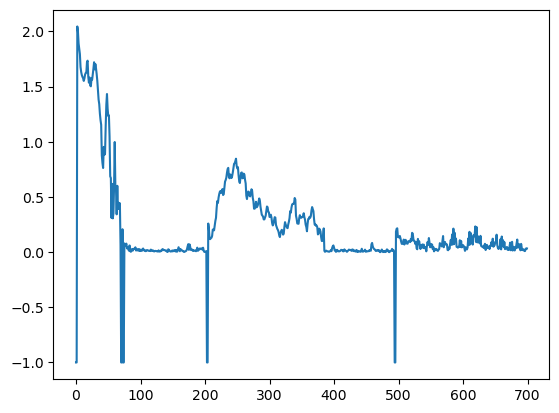

In [59]:
plt.plot(M[:700])